In [189]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import textacy
import numpy as np
import pandas as pd 
import json
import seaborn as sns
from sklearn.cross_validation import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Input, Merge, SpatialDropout1D, Convolution1D, MaxPooling1D, LSTM
import random

# Define global variables

In [ ]:
MAX_NUM = 10000
nlp = spacy.load('en')

In [191]:
RAW_USER_JSON = './data/yelp/user.json'
RAW_TIP_JSON = './data/yelp/tip.json'
RAW_CHECKIN_JSON = './data/yelp/checkin.json'
RAW_PHOTO_JSON = './data/yelp/photos.json'
RAW_REVIEW_JSON = './data/yelp/review.json'
RAW_BUSINESS_JSON = './data/yelp/business.json'

# Take a look at data format

In [192]:
def showFirst(JSON):
    f = open(JSON)
    line = json.loads(f.readline())
    df = pd.DataFrame(columns=['key','value'])
    for key, value in line.items():
        df = df.append({'key':key, 'value':value}, ignore_index=True)
    print(df)

In [193]:
showFirst(RAW_USER_JSON)

                   key                                              value
0              user_id                             oMy_rEb0UBEmMlu-zcxnoQ
1                 name                                             Johnny
2         review_count                                                  8
3        yelping_since                                         2014-11-03
4              friends  [cvVMmlU1ouS3I5fhutaryQ, nj6UZ8tdGo8YJ9lUMTVWN...
5               useful                                                  0
6                funny                                                  0
7                 cool                                                  0
8                 fans                                                  0
9                elite                                                 []
10       average_stars                                               4.67
11      compliment_hot                                                  0
12     compliment_more                

In [194]:
showFirst(RAW_TIP_JSON)

           key                                  value
0         text  Get here early enough to have dinner.
1         date                             2012-07-15
2        likes                                      0
3  business_id                 tJRDll5yqpZwehenzE2cSg
4      user_id                 zcTZk7OG8ovAmh_fenH21g


In [195]:
showFirst(RAW_CHECKIN_JSON)

           key                                              value
0         time  {'Thursday': {'21:00': 4, '1:00': 1, '4:00': 1...
1  business_id                             7KPBkxAOEtb3QeIL9PEErg


In [196]:
showFirst(RAW_PHOTO_JSON)

           key                   value
0      caption                        
1     photo_id  soK1szeyan202jnsGhUDmA
2  business_id  OnAzbTDn79W6CFZIriqLrA
3        label                  inside


In [197]:
showFirst(RAW_BUSINESS_JSON)

             key                                              value
0    business_id                             FYWN1wneV18bWNgQjJ2GNg
1           name                                   Dental by Design
2   neighborhood                                                   
3        address                           4855 E Warner Rd, Ste B9
4           city                                          Ahwatukee
5          state                                                 AZ
6    postal_code                                              85044
7       latitude                                            33.3307
8      longitude                                           -111.979
9          stars                                                  4
10  review_count                                                 22
11       is_open                                                  1
12    attributes  {'AcceptsInsurance': True, 'ByAppointmentOnly'...
13    categories  [Dentists, General Dentistry, 

In [198]:
showFirst(RAW_REVIEW_JSON)

           key                                              value
0    review_id                             v0i_UHJMo_hPBq9bxWvW4w
1      user_id                             bv2nCi5Qv5vroFiqKGopiw
2  business_id                             0W4lkclzZThpx3V65bVgig
3        stars                                                  5
4         date                                         2016-05-28
5         text  Love the staff, love the meat, love the place....
6       useful                                                  0
7        funny                                                  0
8         cool                                                  0


# Define some helpful function

explore business list

In [294]:
def extract_attributes(cols, raw_json, MAX = 1000):
    lst = []
    records = textacy.io.read_json(raw_json, mode='rt', lines=True)
    for record,_ in zip(records, range(MAX)):
        t_lst = []
        for col in cols:
            t_lst.append(record[col])            
        lst.append(t_lst)
    df = pd.DataFrame(lst, columns=cols)
    return df

In [297]:
df_business = extract_attributes(cols = ['business_id', 'latitude','longitude','stars','review_count'],
                                 raw_json = RAW_BUSINESS_JSON,
                                 MAX = 1000)
df_business.head()

,business_id,latitude,longitude,stars,review_count
0,FYWN1wneV18bWNgQjJ2GNg,33.330690,-111.978599,4.0,22
1,He-G7vWjzVUysIKrfNbPUQ,40.291685,-80.104900,3.0,11
2,KQPW8lFf1y5BT2MxiSZ3QA,33.524903,-112.115310,1.5,18
3,8DShNS-LuFqpEWIp0HxijA,33.383147,-111.964725,3.0,9
4,PfOCPjBrlQAnz__NXj9h_w,41.119535,-81.475690,3.5,116


Filter out rules

In [199]:
# define rules to filter out unuseful tokens
def filter_token(token):
    if(token.is_punct or \
       token.is_digit or \
       token.is_space or \
       token.like_num or 
       token.is_stop) :
        return(False)
    else:
        return(True)

Read review `text` from json

In [200]:
# yield entire text for one review
def generate_review():
    reviews = textacy.io.read_json(RAW_REVIEW_JSON, mode='rt', lines=True)
    for review in reviews:
        yield review['text']

In [201]:
for text in generate_review():
    print(text)
    break

Love the staff, love the meat, love the place. Prepare for a long line around lunch or dinner hours. 

They ask you how you want you meat, lean or something maybe, I can't remember. Just say you don't want it too fatty. 

Get a half sour pickle and a hot pepper. Hand cut french fries too.


# Phrase Model

## Prepare Sentence (tokens) List

- Process
    1. filter out based on rules
    2. lemmatize
    
    
- Output:  
**[**<br/>
[sentence 1 token 1, sentence 1 token 2], ..., [sentence 1 token K1],<br/>
[sentence 2 token 1, sentence 2 token 2], ..., [sentence 2 token K2],<br/>
...<br/>
[sentence N token 1, sentence N token 2], ..., [sentence N token KN]<br/>
**]**

In [202]:
def generate_list(max_num = MAX_NUM):
    all_reviews = generate_review()
    df = []
    
    for doc,_ in zip(nlp.pipe(all_reviews, batch_size=10, n_threads=3),  # parallel processing
                     range(max_num)):                                    # only MAX_NUM files
        for sent in doc.sents:
            df.append( [token.lemma_ for token in sent if filter_token(token) and token.lemma_ != '-PRON-'] )
    return(df)

In [203]:
unigram_sentences = generate_list()
len(unigram_sentences) # Number of sentences

105450

In [204]:
unigram_sentences[:5]

[['love', 'staff', 'love', 'meat', 'love', 'place'],
 ['prepare', 'long', 'line', 'lunch', 'dinner', 'hour'],
 ['ask', 'want', 'meat', 'lean', 'maybe', 'not', 'remember'],
 ['just', 'not', 'want', 'fatty'],
 ['get', 'half', 'sour', 'pickle', 'hot', 'pepper']]

## Train phrase model

In [205]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [206]:
bigram_model = Phraser(Phrases(unigram_sentences))
trigram_model = Phraser(Phrases(bigram_model[unigram_sentences]))

## Apply Phrase Model

- Process
    1. filter out based on rules
    2. lemmatize
    3. apply bigram and trigram phrase model


- Output:  
**[**<br/>
[Doc 1 token 1, Doc 1 token 2], ..., [Doc 1 token K1],<br/>
[Doc 2 token 1, Doc 2 token 2], ..., [Doc 2 token K2],<br/>
...<br/>
[Doc N token 1, Doc N token 2], ..., [Doc N token KN]<br/>
**]**

In [207]:
def apply_phrase_model(max_num = MAX_NUM):
    df = []
    for doc,_ in zip(nlp.pipe(generate_review(), batch_size=10, n_threads=3),
                   range(max_num)):
        unigram_review =  [token.lemma_ for token in doc if filter_token(token) and token.lemma_ != '-PRON-']
        bigram_review = bigram_model[unigram_review]
        trigram_review = trigram_model[bigram_review]
        df.append(trigram_review)
    return(df)

In [208]:
phrased_reviews = apply_phrase_model()
len(phrased_reviews)

10000

Take a look at bi- and tri- grams

In [209]:
' / '.join([word for phrased_review in phrased_reviews for word in phrased_review if '_' in word ][:15])

'long_line / lunch_dinner / not_remember / hot_pepper / french_fry / staff_helpful_friendly / beef_tartar / pork_belly / smoke_meat / seat_outside / will_not / cajun_fry / almond_croissant / las_vegas / las_vegas'

# Topic Modelling - `gensim`

<img src="https://s3.amazonaws.com/skipgram-images/LDA.png" width= 400>

In [210]:
from gensim import corpora
from gensim.models import LdaMulticore
import pyLDAvis.gensim as gensimvis
import pyLDAvis

Create gensim `dictionary`

In [211]:
dictionary = corpora.Dictionary(phrased_reviews)
print(dictionary)

Dictionary(31197 unique tokens: ['ask', 'cut', 'fatty', 'french_fry', 'get']...)


An example of using dictionary (essentially just document-term matrix)

In [212]:
dictionary.doc2bow(phrased_reviews[300])

[(19, 1),
 (57, 1),
 (77, 1),
 (78, 1),
 (89, 2),
 (91, 1),
 (99, 2),
 (138, 1),
 (230, 1),
 (249, 1),
 (328, 1),
 (530, 1),
 (968, 1),
 (1200, 1),
 (1384, 1),
 (1471, 1),
 (1771, 1),
 (3740, 1),
 (3741, 1),
 (3742, 1),
 (3743, 1)]

Create gensim `corpus`

In [213]:
corpus = [dictionary.doc2bow(phrased_review) for phrased_review in phrased_reviews]
corpora.MmCorpus.serialize('./model/yelp_gensim_corpus.mm', corpus)  # store to disk, for later use
corpus = corpora.MmCorpus('./model/yelp_gensim_corpus.mm')

Train LDA model

In [214]:
lda = LdaMulticore(corpus, 
                   num_topics = 5, 
                   id2word = dictionary, 
                   workers = 3)

Take a look at top terms in first topic

In [215]:
lda.show_topic(0, topn=10)

[('not', 0.014495503),
 ('the', 0.013054001),
 ('be', 0.011199601),
 ('great', 0.010389214),
 ('place', 0.009433869),
 ('food', 0.008967895),
 ('come', 0.007817965),
 ('good', 0.0076900036),
 ('like', 0.0074591003),
 ('time', 0.0066083395)]

Visualization

In [216]:
vis_data  = gensimvis.prepare(lda, corpus, dictionary)

/Users/shiwang/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [217]:
pyLDAvis.display(vis_data)

# Topic Modeling - `textacy`

Create Document-Term Matrix

In [218]:
vectorizer = textacy.vsm.Vectorizer(tf_type='linear', min_df = 1)
doc_term_matrix = vectorizer.fit_transform(phrased_reviews)
doc_term_matrix

<10000x31197 sparse matrix of type '<class 'numpy.int32'>'
	with 496916 stored elements in Compressed Sparse Row format>

Train Topic Model

In [219]:
model = textacy.tm.TopicModel('lda', n_topics=5) 
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape

/Users/shiwang/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


(10000, 5)

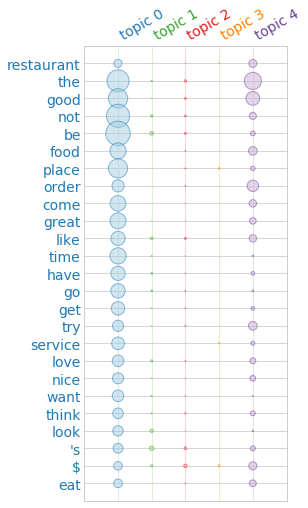

In [220]:
model.termite_plot(doc_term_matrix,  
                   vectorizer.id_to_term,
                   highlight_topics=[0,1,2,3,4])

# Predict review stars

## Prepare constant length reviews

/Users/shiwang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


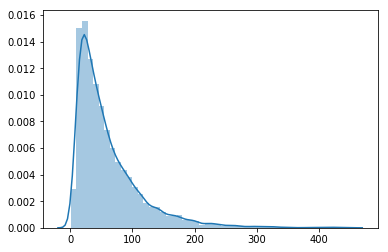

In [221]:
sns.distplot([len(review) for review in phrased_reviews])

In [222]:
def pad_trim_review(review, MAX_LEN = 50):
    l = len(review)
    if  l >= MAX_LEN:
        return(review[:MAX_LEN])
    else:
        return(review + ['<PAD/>'] * (MAX_LEN - l))

In [223]:
pad_trim_review(phrased_reviews[0])[:5],pad_trim_review(phrased_reviews[0])[-5:]

(['love', 'staff', 'love', 'meat', 'love'],
 ['<PAD/>', '<PAD/>', '<PAD/>', '<PAD/>', '<PAD/>'])

## Generate index-based input

In [224]:
dictionary = corpora.Dictionary(phrased_reviews)
phrased_reviews_padded = [pad_trim_review(x) for x in phrased_reviews]
phrased_reviews_padded_index = [dictionary.doc2idx(x, unknown_word_index=len(dictionary)) for x in phrased_reviews_padded]

In [225]:
VOCAB_SIZE = len(dictionary) + 1
VOCAB_SIZE

31198

In [226]:
phrased_reviews_padded_index[0][:5], phrased_reviews_padded_index[0][-5:]

([12, 22, 12, 15, 12], [31197, 31197, 31197, 31197, 31197])

In [227]:
phrased_reviews_padded_index = np.array(phrased_reviews_padded_index)
phrased_reviews_padded_index.shape

(10000, 50)

## Extract target

In [228]:
def generate_stars():
    reviews = textacy.io.read_json(RAW_REVIEW_JSON, mode='rt', lines=True)
    for review in reviews:
        yield(review['stars'])

In [229]:
stars = [star for star, _ in zip(generate_stars(), range(MAX_NUM))]
stars[:5]

[5, 5, 5, 5, 4]

In [230]:
stars = np.array(stars).reshape(-1,1)
stars.shape

(10000, 1)

/Users/shiwang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


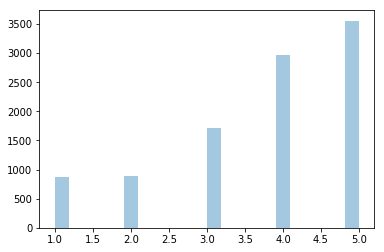

In [231]:
sns.distplot(stars,kde=False)

## Generate Training and Testing set

In [279]:
data = np.append(phrased_reviews_padded_index, stars,axis = 1) # continous
data.shape

(10000, 51)

In [274]:
data = np.append(phrased_reviews_padded_index, stars,axis = 1) #binary
data = data[data[:,-1] != 3]
data[:,-1] = [0 if x < 3 else 1 for x in data[:,-1]]
data.shape

(8284, 51)

In [280]:
random.seed(1)
np.random.shuffle(data)
train, test = train_test_split(data, test_size = 0.15,random_state = 0)
X_train = train[:,:-1]
X_test = test[:,:-1]
Y_train = train[:,-1]
Y_test = test[:,-1]

## Define LSTM network

In [281]:
MAX_LEN = 50
VOCAB_SIZE
embedding_dim = 25
lstm_units = 120
batch_size = 64

In [282]:
model = Sequential()
model.add(Embedding(input_dim = VOCAB_SIZE, 
                    output_dim = embedding_dim, 
                    input_length = MAX_LEN))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(units = lstm_units, 
               dropout = 0.2,  
               recurrent_dropout = 0.2))
model.add(Dense(60, activation='relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(1, activation='relu')) # continous
#model.add(Dense(1, activation='sigmoid')) # binary
model.summary()

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 50, 25)            779950    
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, 50, 25)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 120)               70080     
_________________________________________________________________
dense_15 (Dense)             (None, 60)                7260      
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 61        
Total params: 857,351
Trainable params: 857,351
Non-trainable params: 0
_________________________________________________________________


/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


## Model training

In [278]:
model.compile(loss='binary_crossentropy', 
              optimizer = optimizers.Adam(lr=0.001), 
              metrics=['accuracy'])
model.fit(X_train, 
          Y_train, 
          batch_size = batch_size, 
          validation_data=(X_test, Y_test), 
          epochs = 10)

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

Train on 7041 samples, validate on 1243 samples
Epoch 1/10
7041/7041 [==============================] - 10s 1ms/step - loss: 0.5405 - acc: 0.7823 - val_loss: 0.4969 - val_acc: 0.7916
Epoch 2/10
7041/7041 [==============================] - 7s 1ms/step - loss: 0.4128 - acc: 0.8350 - val_loss: 0.4094 - val_acc: 0.8648
Epoch 3/10
7041/7041 [==============================] - 7s 1ms/step - loss: 0.2646 - acc: 0.9068 - val_loss: 0.3203 - val_acc: 0.8850
Epoch 4/10
7041/7041 [==============================] - 7s 1ms/step - loss: 0.1965 - acc: 0.9359 - val_loss: 0.3240 - val_acc: 0.8954
Epoch 5/10
7041/7041 [==============================] - 7s 1ms/step - loss: 0.1357 - acc: 0.9565 - val_loss: 0.3098 - val_acc: 0.8817
Epoch 6/10
7041/7041 [==============================] - 7s 1ms/step - loss: 0.1029 - acc: 0.9692 - val_loss: 0.3255 - val_acc: 0.8914
Epoch 7/10
7041/7041 [==============================] - 7s 963us/step - loss: 0.0807 - acc: 0.9768 - val_loss: 0.3245 - val_acc: 0.8825
Epoch 8/10


In [283]:
model.compile(loss='mean_squared_error', 
              optimizer= optimizers.Adam(lr=0.001), 
              metrics=['mae'])
model.fit(X_train, 
          Y_train, 
          batch_size = batch_size, 
          validation_data=(X_test, Y_test), 
          epochs = 10)

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

Train on 8500 samples, validate on 1500 samples
Epoch 1/10
8500/8500 [==============================] - 11s 1ms/step - loss: 3.4113 - mean_absolute_error: 1.4562 - val_loss: 1.5131 - val_mean_absolute_error: 0.9669
Epoch 2/10
8500/8500 [==============================] - 8s 995us/step - loss: 2.0851 - mean_absolute_error: 1.1789 - val_loss: 1.4755 - val_mean_absolute_error: 1.0007
Epoch 3/10
8500/8500 [==============================] - 8s 976us/step - loss: 2.0436 - mean_absolute_error: 1.1654 - val_loss: 1.4726 - val_mean_absolute_error: 1.0302
Epoch 4/10
8500/8500 [==============================] - 8s 979us/step - loss: 1.7889 - mean_absolute_error: 1.0782 - val_loss: 1.1768 - val_mean_absolute_error: 0.8571
Epoch 5/10
8500/8500 [==============================] - 8s 989us/step - loss: 1.5029 - mean_absolute_error: 0.9856 - val_loss: 1.1340 - val_mean_absolute_error: 0.8390
Epoch 6/10
8500/8500 [==============================] - 9s 1ms/step - loss: 1.2611 - mean_absolute_error: 0.8955 